# Natural Computing - Assignment 3 - Artificial Immune Systems
## Exercise 2 - Intrusion Detection for Unix Processes
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

This file contains our code for exercise 2 of the "Artificial Immune Systems" assignment of the Natural Computing course.

### Imports

In [1]:
from subprocess import Popen, PIPE, STDOUT
from sklearn.metrics import auc
import matplotlib.pyplot as plt 
import numpy as np

### Interfacing with the Java implementation of the Negative Selection algorithm

In [2]:
def get_negsel_outputs(test_filename, 
                       train_filename,
                       alphabet_filename,
                       negsel_folder="negative-selection",
                       n=10, r=4, c=True, l=True):
    
    # Make sure that negsel_folder ends in / if it is not empty
    negsel_folder += "/" if not negsel_folder.endswith("/") and negsel_folder else ""
    
    # Create command using given filenames and parameters
    command = f"java -jar {negsel_folder}negsel2.jar " \
              f"-alphabet file://{negsel_folder}{alphabet_filename} " \
              f"-self {negsel_folder}{train_filename} " \
              f"-n {n} -r {r} {'-c' if c else ''} {'-l' if l else ''} " \
              f"< {negsel_folder}{test_filename}"
    
    # Run the command
    process = Popen(command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=2, close_fds=True)
    
    # Extract and return output values (if multiple values are returned for one line, use the average)
    outputs = []
    for line in iter(process.stdout.readline, b''):
        values = [float(val) for val in line.rstrip().decode('utf-8').split(" ")]
        outputs.append(np.average(values) if values[0] == values[0] else 0.0)
    return outputs

### Preprocessing

In [3]:
def extract_self_foreign(folder_name, data_type, parts=[1,2,3]):
    
    # Make sure that negsel_folder ends in / if it is not empty
    folder_name += "/" if not folder_name.endswith("/") and folder_name else ""
    
    # Extract data from the desired parts
    data, labels = [], []
    for part in parts:
        # Set the correct file location
        loc = f"{folder_name}{data_type}.{part}"
        
        # Extract the test data of this part
        with open(f"{loc}.test", "r") as f:
            data.extend([line.rstrip() for line in f.readlines()])
        
        # Extract the labels of this part
        with open(f"{loc}.labels", "r") as f:
            labels.extend([int(line.rstrip()) for line in f.readlines()])
            
    # Convert test data and labels to np arrays
    data = np.array(data)
    labels = np.array(labels)
    
    # Extract self and foreign test data
    self = data[labels == 0].tolist()
    foreign = data[labels == 1].tolist()
    
    # Return self and foreign test data
    return self, foreign

In [4]:
cert_self, cert_foreign = extract_self_foreign("negative-selection/syscalls/snd-cert", "snd-cert", [1,2,3])
unm_self, unm_foreign = extract_self_foreign("negative-selection/syscalls/snd-unm", "snd-unm", [1,2,3])

In [5]:
def write_to_file(data, folder_name, filename):
    
    # Make sure that negsel_folder ends in / if it is not empty
    folder_name += "/" if not folder_name.endswith("/") and folder_name else ""
    
    # Write the provided data to the specified file, one line at a time
    with open(f"{folder_name}{filename}", "w") as f:
        for line in data:
            f.write(f"{line}\n")

In [6]:
write_to_file(cert_self, "negative-selection/syscalls/snd-cert", "snd-cert.self.test")
write_to_file(cert_foreign, "negative-selection/syscalls/snd-cert", "snd-cert.foreign.test")
write_to_file(unm_self, "negative-selection/syscalls/snd-unm", "snd-unm.self.test")
write_to_file(unm_foreign, "negative-selection/syscalls/snd-unm", "snd-unm.foreign.test")

### Computing ROC-AUC

In [7]:
def roc_auc(self_outputs, foreign_outputs, title="ROC Curve"):
    # Initialize lists for True Positive Rate (sensitivity) and True Negative Rate (specificity) values
    TPRs, FPRs = [], []
    
    # Merge outputs
    merged_outputs = self_outputs + foreign_outputs
    cut_off_scores = sorted(set(merged_outputs))

    # Compute sensitivity and specificity for each cut-off score in the merged outputs
    for cut_off_score in cut_off_scores:
        # Calculate TPR/sensitivity: TP/(TP+FN) (% of "foreign_outputs" > cut-off score)
        TPRs.append(sum(np.array(foreign_outputs) > cut_off_score) / len(foreign_outputs))

        # Calculate TNR/specificity: TN/(TN+FP) ($% of "self_outputs" < cut-off score)
        FPRs.append(1 - sum(np.array(self_outputs) < cut_off_score) / len(self_outputs))
    
    # Plot ROC curve
    plt.plot(FPRs, TPRs)
    plt.plot([0.0, 1.0], [0.0, 1.0], ls='--')
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.ylabel('True Positive Rate (sensitivity)')
    plt.title(title)
    plt.show()
    
    # Compute and print AUC score (AUC is computed using FPRs and TPRs)
    print(f"ROC-AUC score = {auc(FPRs, TPRs)}")

### Running the algorithm

In [8]:
cert_self_outputs = get_negsel_outputs("syscalls/snd-cert/snd-cert.self.test", 
                                       "syscalls/snd-cert/snd-cert.train", 
                                       "syscalls/snd-cert/snd-cert.alpha")
cert_foreign_outputs = get_negsel_outputs("syscalls/snd-cert/snd-cert.foreign.test", 
                                          "syscalls/snd-cert/snd-cert.train", 
                                          "syscalls/snd-cert/snd-cert.alpha")

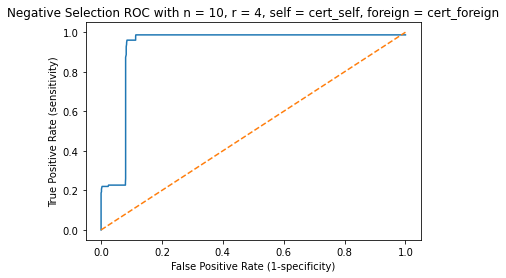

ROC-AUC score = 0.924105376344086


In [9]:
roc_auc(cert_self_outputs, 
        cert_foreign_outputs, 
        "Negative Selection ROC with n = 10, r = 4, self = cert_self, foreign = cert_foreign")

In [10]:
unm_self_outputs = get_negsel_outputs("syscalls/snd-unm/snd-unm.self.test", 
                                      "syscalls/snd-unm/snd-unm.train", 
                                      "syscalls/snd-unm/snd-unm.alpha")
unm_foreign_outputs = get_negsel_outputs("syscalls/snd-unm/snd-unm.foreign.test", 
                                         "syscalls/snd-unm/snd-unm.train", 
                                         "syscalls/snd-unm/snd-unm.alpha")

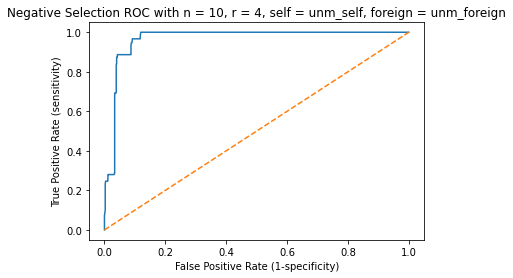

ROC-AUC score = 0.9667720430107527


In [11]:
roc_auc(unm_self_outputs, 
        unm_foreign_outputs, 
        "Negative Selection ROC with n = 10, r = 4, self = unm_self, foreign = unm_foreign")